In [1]:
import os
import re
from collections import Counter
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
cm = 1/2.54

# force GPU device
os.environ["CUDA_VISIBLE_DEVICES"]='1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf

from keras.src.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.src.layers import SimpleRNN, LSTM, Dense, Dropout, Bidirectional
from keras import Sequential, Input
from keras.losses import CategoricalCrossentropy, CategoricalFocalCrossentropy
from keras.optimizers import Adam
from keras.models import load_model
from keras.metrics import CategoricalAccuracy, TopKCategoricalAccuracy


from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

from utils import *

In [2]:
max_sequence_length = 100
experiment_name = 'netinfo'
top_k = 3

In [3]:
checkpoint_path = f'saves/{experiment_name}'
model_path = f'{checkpoint_path}/model.keras'
log_path = f'{checkpoint_path}/log.csv'
history_path = f'{checkpoint_path}/history.npy'

# ensure directory exists
if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)

In [4]:
data_directory = '/home/jrosendahl/datasets/cadets/sequences_export_benign_filetypes_more/'
unusable_threshold = 10
rare_threshold = 50
splits = (0.7, 0.15, 0.15)

max_sequence_length = 100

assert(sum(splits) == 1)

print(f'experiment parameters: \n{data_directory=} \n{unusable_threshold=} \n{rare_threshold=} \n{splits=} \n{max_sequence_length=}')

experiment parameters: 
data_directory='/home/jrosendahl/datasets/cadets/sequences_export_benign_filetypes_more/' 
unusable_threshold=10 
rare_threshold=50 
splits=(0.7, 0.15, 0.15) 
max_sequence_length=100


In [5]:
total_classes = 0

# unusable classes will be removed from the dataset
unusable_classes = []
# rare classes will be oversampled
rare_classes = []

# all classes in training data (all classes - unusable classes)
classes = []

# walk all files, build unusable_classes, rare_classes
classes_occurrences = Counter()
for filename in os.listdir(data_directory):
    label = class_from_filename(filename)
    classes_occurrences[label] += 1

total_classes = len(classes_occurrences)
for label, count in classes_occurrences.items():
    if count < unusable_threshold:
        unusable_classes.append(label)
    elif count < rare_threshold:
        rare_classes.append(label)
        classes.append(label)
    else:
        classes.append(label)

print(f'Total classes: {total_classes}')
print(f'Unusable classes: {len(unusable_classes)}')
print(f'\t{unusable_classes}')
print(f'Rare classes: {len(rare_classes)}')
print(f'\t{rare_classes}')

labels_cardinality = len(set(classes))
print(f'Usable classes: {labels_cardinality}')

Total classes: 118
Unusable classes: 51
	['ping', 'pwd_mkdb', 'vi', 'tr', 'uname', 'msgs', 'screen', 'pw', 'bzip2', 'bzcat', 'nginx', 'stat', 'tail', 'smtp', 'kenv', 'nawk', 'ssh', 'chown', 'cut', 'php-fpm', 'jot', 'xz', 'diff', 'bounce', 'links', 'ipfw', 'touch', 'env', 'pfctl', 'minions', 'csh', 'kldstat', 'su', 'nohup', 'stty', 'df', 'limits', 'id', 'postmap', 'ifconfig', 'chkgrp', 'ipfstat', 'locale', 'devd', 'uniq', 'XIM', 'getty', 'which', 'init', 'test', 'nice']
Rare classes: 20
	['wc', 'grep', 'mktemp', 'less', 'tty', 'mailwrapper', 'kill', 'lockf', 'mount', 'tee', 'expr', 'ps', 'route', 'sed', 'cmp', 'egrep', 'sort', 'basename', 'awk', 'mail']
Usable classes: 67


In [6]:
# split into train, validation, test
labels_set = set()

filenames_all = []

filenames_train = []
filenames_val = []
filenames_test = []

for filename in os.listdir(data_directory):
    label = class_from_filename(filename)
    if label in unusable_classes:
        continue
    labels_set.add(label)
    filenames_all.append(filename)

# stratisfied split
test_vs_val = splits[2] / (splits[1] + splits[2])
filenames_train, filenames_val_test = train_test_split(filenames_all, test_size=splits[1]+splits[2], stratify=[class_from_filename(f) for f in filenames_all])
filenames_val, filenames_test = train_test_split(filenames_val_test, test_size=test_vs_val, stratify=[class_from_filename(f) for f in filenames_val_test])

print(f'Train: {len(filenames_train)}')
print(f'Validation: {len(filenames_val)}')
print(f'Test: {len(filenames_test)}')

# build labels_map in alphabetical order
labels_map = {}
for i, label in enumerate(sorted(labels_set)):
    labels_map[label] = i

Train: 150475
Validation: 32245
Test: 32245


In [7]:
# load data
count_files_read = 0
count_sequences_split = 0
count_splits = 0

preprocessor = Preprocessor(['TYPE', 'PRED_OBJ_NETINFO'])

def parse_file(filename) -> tuple[list[int], list[list[int]]]:
    """
    Parse a file and return the vectorized data. Not a pure function (calls parse_line)!
    """
    global count_files_read, count_sequences_split, count_splits

    y_list: list[int] = []
    X_list: list[list[int]] = []
    y = class_from_filename(filename)
    y = labels_map[y]
    with open(os.path.join(data_directory, filename), 'r') as f:
        lines = f.readlines()
        count_files_read += 1
    if count_files_read % 50000 == 0:
        print(f'Files read: {count_files_read}')
    X = []
    for line in lines:
        line_res = preprocessor.process(line)
        event = line_res['TYPE']
        net1_localaddr = line_res['PRED_OBJ1_LOCALIP']
        net1_remoteaddr = line_res['PRED_OBJ1_REMOTEIP']
        net2_localaddr = line_res['PRED_OBJ2_LOCALIP']
        net2_remoteaddr = line_res['PRED_OBJ2_REMOTEIP']
        net1_localport = line_res['PRED_OBJ1_LOCALPORT']
        net1_remoteport = line_res['PRED_OBJ1_REMOTEPORT']
        net2_localport = line_res['PRED_OBJ2_LOCALPORT']
        net2_remoteport = line_res['PRED_OBJ2_REMOTEPORT']
        X.append((event, net1_localaddr, net1_localport, net1_remoteaddr, net1_remoteport, net2_localaddr, net2_localport, net2_remoteaddr, net2_remoteport))

    # check if sequence needs to be split
    if len(X) > max_sequence_length:
        count_sequences_split += 1
        count_splits += len(X) // max_sequence_length
        for i in range(0, len(X), max_sequence_length):
            y_list.append(y)
            X_list.append(X[i:i+max_sequence_length])
        assert len(X_list[0]) == max_sequence_length
    else:
        y_list.append(y)
        X_list.append(X)

    # transform elements to numpy arrays
    y_list = np.array(y_list)
    X_list = [np.array(x) for x in X_list]

    assert len(y_list) == len(X_list)
    return y_list, X_list


y_train = []
X_train = []
y_val = []
X_val = []
y_test = []
X_test = []

for filename in filenames_train:
    try:
        y_list, X_list = parse_file(filename)
    except Exception as e:
        print(f'Error parsing file: {filename}')
        raise e
    y_train.extend(y_list)
    X_train.extend(X_list)

for filename in filenames_val:
    y_list, X_list = parse_file(filename)
    y_val.extend(y_list)
    X_val.extend(X_list)

for filename in filenames_test:
    y_list, X_list = parse_file(filename)
    y_test.extend(y_list)
    X_test.extend(X_list)

assert len(X_train) == len(y_train)
assert len(X_val) == len(y_val)
assert len(X_test) == len(y_test)

print(f'Files read: {count_files_read}')
print(f'Sequences split: {count_sequences_split}')
print(f'Splits: {count_splits}')


event_types_map = preprocessor.event_types_map
addr_map = preprocessor.addr_map
port_map = preprocessor.port_map

event_types_cardinality = len(event_types_map)

print(f'Event types: {event_types_cardinality}')
print(f'Addresses: {len(addr_map)}')
print(f'Ports: {len(port_map)}')

# print lengths
print(f'Train: {len(y_train)}')
print(f'Validation: {len(y_val)}')
print(f'Test: {len(y_test)}')

Files read: 50000


Files read: 100000


Files read: 150000


Files read: 200000


Files read: 214965
Sequences split: 22897
Splits: 132960
Event types: 29
Addresses: 4
Ports: 9
Train: 247249
Validation: 48541
Test: 52084


In [8]:
# debug print all maps (sorted)
print('Event types:')
for k, v in sorted(event_types_map.items(), key=lambda x: x[1]):
    print(f'{v}: {k}', end=', ')
print()

print('Addresses:')
for k, v in sorted(addr_map.items(), key=lambda x: x[1]):
    print(f'{v}: {k}', end=', ')
print()

print('Ports:')
for k, v in sorted(port_map.items(), key=lambda x: x[1]):
    print(f'{v}: {k}', end=', ')
print()

Event types:
0: EVENT_EXECUTE, 1: EVENT_OPEN, 2: EVENT_READ, 3: EVENT_CLOSE, 4: EVENT_MMAP, 5: EVENT_WRITE, 6: EVENT_EXIT, 7: EVENT_CONNECT, 8: EVENT_SENDTO, 9: EVENT_LSEEK, 10: EVENT_CHANGE_PRINCIPAL, 11: EVENT_LOGIN, 12: EVENT_MODIFY_PROCESS, 13: EVENT_FCNTL, 14: EVENT_RECVFROM, 15: EVENT_MPROTECT, 16: EVENT_CREATE_OBJECT, 17: EVENT_ACCEPT, 18: EVENT_UNLINK, 19: EVENT_FORK, 20: EVENT_MODIFY_FILE_ATTRIBUTES, 21: EVENT_LINK, 22: EVENT_RENAME, 23: EVENT_TRUNCATE, 24: EVENT_SIGNAL, 25: EVENT_OTHER, 26: EVENT_SENDMSG, 27: EVENT_RECVMSG, 28: EVENT_BIND, 
Addresses:
0: None, 1: Loopback, 2: Other, 3: Private, 
Ports:
0: None, 1: Other, 2: DNS, 3: EXEC, 4: IMAP, 5: SMTP, 6: TCPMUX, 7: HTTP, 8: SSH, 


In [9]:
# turn labels map into bidirectional map
for k, v in labels_map.copy().items():
    labels_map[v] = k

# turn feature maps into bidirectional maps
for k, v in event_types_map.copy().items():
    event_types_map[v] = k

for k, v in addr_map.copy().items():
    addr_map[v] = k

for k, v in port_map.copy().items():
    port_map[v] = k

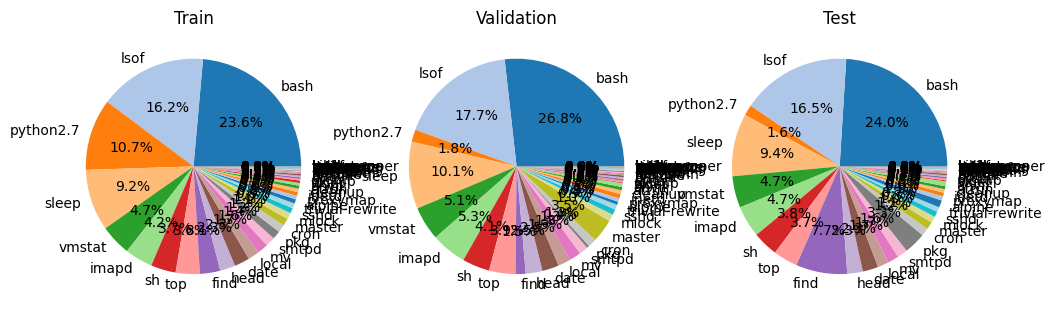

In [10]:
# print distributions in all 3 sets
train_distribution = Counter(y_train)
val_distribution = Counter(y_val)
test_distribution = Counter(y_test)

# plot 3 pie plots, use same colors for same classes
colors = plt.cm.tab20.colors
colors = [ colors[i % 20] for i in range(labels_cardinality) ]

# sort labels by occurence in training set
sorted_labels = sorted(train_distribution, key=train_distribution.get, reverse=True)

# sort all distributions by sorted_labels
train_distribution = [train_distribution[label] for label in sorted_labels]
val_distribution = [val_distribution[label] for label in sorted_labels]
test_distribution = [test_distribution[label] for label in sorted_labels]

# transform labels to names
sorted_labels = [labels_map[label] for label in sorted_labels]

fig, axs = plt.subplots(1, 3, figsize=(30*cm, 10*cm))
axs[0].pie(train_distribution, labels=sorted_labels, colors=colors, autopct='%1.1f%%')
axs[0].set_title('Train')
axs[1].pie(val_distribution, labels=sorted_labels, colors=colors, autopct='%1.1f%%')
axs[1].set_title('Validation')
axs[2].pie(test_distribution, labels=sorted_labels, colors=colors, autopct='%1.1f%%')
axs[2].set_title('Test')
plt.savefig(f'{checkpoint_path}/distributions.png')
plt.show()

In [11]:
# one-hot encode labels
y_train = np.eye(labels_cardinality)[y_train]
y_val = np.eye(labels_cardinality)[y_val]
y_test = np.eye(labels_cardinality)[y_test]

In [12]:
# one-hot encode features
# at this point, X_* are lists of tuples of vectorized features
def encode_features(sequence: np.ndarray) -> np.ndarray:
    # Precompute identity matrices
    event_eye = np.eye(event_types_cardinality)
    addr_eye = np.eye(len(addr_map))
    port_eye = np.eye(len(port_map))

    # Initialize the output array with precomputed shapes
    encoded_seq = np.empty((len(sequence), event_eye.shape[1] + 4 * addr_eye.shape[1] + 4 * port_eye.shape[1]))


    for i, feature_vector in enumerate(sequence):
        # one-hot
        event = event_eye[feature_vector[0]]
        addr1 = addr_eye[feature_vector[1]]
        port1 = port_eye[feature_vector[2]]
        addr2 = addr_eye[feature_vector[3]]
        port2 = port_eye[feature_vector[4]]
        addr3 = addr_eye[feature_vector[5]]
        port3 = port_eye[feature_vector[6]]
        addr4 = addr_eye[feature_vector[7]]
        port4 = port_eye[feature_vector[8]]

        # Concatenate all features into a single feature vector
        encoded_seq[i] = np.concatenate((event, addr1, port1, addr2, port2, addr3, port3, addr4, port4))

    return encoded_seq

X_train = [ encode_features(x) for x in X_train ]
X_val = [ encode_features(x) for x in X_val ]
X_test = [ encode_features(x) for x in X_test ]

In [13]:
feature_vector_cardinality = X_train[0].shape[1]

print(f'Feature vector cardinality: {feature_vector_cardinality}')

Feature vector cardinality: 133


In [14]:
# debug print first sequence first 5 elements
print(X_train[0][:5])

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [15]:
X_train, y_train = shuffle(X_train, y_train)
X_val, y_val = shuffle(X_val, y_val)
X_test, y_test = shuffle(X_test, y_test)

build model

In [16]:
model = Sequential(layers=[
    Input(shape=(None, feature_vector_cardinality)),
    SimpleRNN(128, return_sequences=True),
    SimpleRNN(128, return_sequences=True),
    SimpleRNN(128, return_sequences=False),
    Dense(labels_cardinality, activation='softmax')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, None, 128)      │        33,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, None, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 67)             │         8,643 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,971 (421.76 KB)

 Trainable params: 107,971 (421.76 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        verbose=1,
        mode='auto'
    ),
    ModelCheckpoint(
        filepath=model_path,
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=3,
        verbose=1,
        mode='auto',
        min_lr=1e-7
    ),
    CSVLogger(
        filename=log_path,
        append=True
    )
]

loss = CategoricalCrossentropy()
optimizer = Adam(learning_rate=0.0001)

# class weights
y_train_int = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_int),
    y=y_train_int
)
class_weights_dict = dict(enumerate(class_weights))

metrics = [
    CategoricalAccuracy(name='categorical_accuracy'),
    TopKCategoricalAccuracy(k=top_k, name=f'top_{top_k}_categorical_accuracy'),
]

weighted_metrics = [
    CategoricalAccuracy(name='w_categorical_accuracy'),
    TopKCategoricalAccuracy(k=top_k, name=f'w_top_{top_k}_categorical_accuracy'),
]

# 'categorical_focal_crossentropy'
# 'categorical_crossentropy'
model.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=metrics,
    weighted_metrics=weighted_metrics,
)

train model

In [ ]:
history = model.fit(
    x=Generator(X_train, y_train, 64, max_sequence_length),
    validation_data=Generator(X_val, y_val, 128, max_sequence_length),
    epochs=200,
    callbacks=callbacks,
    class_weight=class_weights_dict
)

# save history to file
with open(history_path, 'wb') as f:
    np.save(f, history.history)

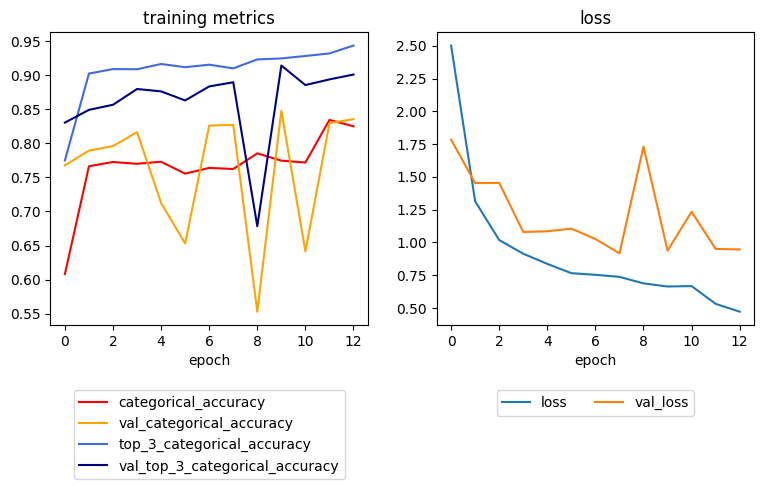

In [19]:
log = pd.read_csv(log_path)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20*cm, 15*cm))

ax1.plot(log['epoch'], log['categorical_accuracy'], label='categorical_accuracy', color='red')
ax1.plot(log['epoch'], log['val_categorical_accuracy'], label='val_categorical_accuracy', color='orange')
ax1.plot(log['epoch'], log[f'top_{top_k}_categorical_accuracy'], label=f'top_{top_k}_categorical_accuracy', color='royalblue')
ax1.plot(log['epoch'], log[f'val_top_{top_k}_categorical_accuracy'], label=f'val_top_{top_k}_categorical_accuracy', color='navy')
ax1.set_title('training metrics')
ax1.set_xlabel('epoch')
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=1)  # Legend below the plot

ax2.plot(log['epoch'], log['loss'], label='loss')
ax2.plot(log['epoch'], log['val_loss'], label='val_loss')
ax2.set_title('loss')
ax2.set_xlabel('epoch')
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2)  # Legend below the plot

fig.tight_layout(rect=[0, 0.1, 1, 1])

plt.savefig(f'{checkpoint_path}/metrics_loss.svg')
plt.show()

In [20]:
# load old model, if needed
try:
    model
except NameError:
    model = load_model(model_path)

In [ ]:
# evaluate model
score = model.evaluate(x=Generator(X_test, y_test, 128, max_sequence_length))

In [22]:
print(f'Test loss: {score[0]}')
print(f'Test accuracy: {score[1]}')

Test loss: 0.6217053532600403
Test accuracy: 0.8633745312690735


In [23]:
# print classification report
y_pred = model.predict(x=Generator(X_test, y_test, 128, max_sequence_length))
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

distinct_labels = [labels_map[i] for i in range(labels_cardinality)]

report = classification_report(y_true, y_pred, target_names=distinct_labels, zero_division=np.nan)
report_dict = classification_report(y_true, y_pred, target_names=distinct_labels, zero_division=np.nan, output_dict=True)

print(report)

# save classification report to file
with open(f'{checkpoint_path}/classification_report.txt', 'w') as f:
    json.dump(report_dict, f)


  1/407 ━━━━━━━━━━━━━━━━━━━━ 4:12 622ms/step


  5/407 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step   


  8/407 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step


 12/407 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step


 15/407 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step


 18/407 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step


 21/407 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step


 24/407 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step


 27/407 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step


 30/407 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step


 33/407 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step


 37/407 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step


 40/407 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step


 43/407 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step


 46/407 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step


 49/407 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step


 52/407 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step


 55/407 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step


 58/407 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step


 61/407 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step


 64/407 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step


 67/407 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step


 70/407 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step


 73/407 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step


 76/407 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step


 79/407 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step


 82/407 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step


 85/407 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step


 88/407 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step


 91/407 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step


 94/407 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step


 97/407 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step


101/407 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step


104/407 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step


107/407 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step


110/407 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step


113/407 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step


116/407 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step


119/407 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step


123/407 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step


126/407 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step


129/407 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step


132/407 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step


135/407 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step


138/407 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step


141/407 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step


144/407 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step


147/407 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step


150/407 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step


153/407 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step


157/407 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step


160/407 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step


163/407 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step


167/407 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step


171/407 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step


174/407 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step


177/407 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step


180/407 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step


183/407 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step


186/407 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step


190/407 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step


193/407 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step


196/407 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step


199/407 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step


202/407 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step


205/407 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step


208/407 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step


211/407 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step


214/407 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step


217/407 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step


221/407 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step


224/407 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step


227/407 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step


230/407 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step


233/407 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step


236/407 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step


239/407 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step


242/407 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


245/407 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


248/407 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


251/407 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


254/407 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


257/407 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


260/407 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


263/407 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


266/407 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


269/407 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


272/407 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


275/407 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


278/407 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


282/407 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


285/407 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


288/407 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


292/407 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


295/407 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


298/407 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


301/407 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


304/407 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


307/407 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


310/407 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


313/407 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


316/407 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


319/407 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


322/407 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


325/407 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


328/407 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


331/407 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


334/407 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


337/407 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


340/407 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


344/407 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


347/407 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


351/407 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


355/407 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


358/407 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


361/407 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


364/407 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


367/407 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


370/407 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


373/407 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


376/407 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


379/407 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


382/407 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


386/407 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


389/407 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


392/407 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


395/407 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


398/407 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


401/407 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


404/407 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


407/407 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


407/407 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step


                 precision    recall  f1-score   support

      adjkerntz       0.00      0.00      0.00        11
         alpine       0.52      0.82      0.64       560
          anvil       0.46      0.44      0.45       378
          atrun       0.97      1.00      0.98       237
            awk       0.10      1.00      0.19         5
       basename       0.00      0.00      0.00         2
           bash       0.95      0.96      0.95     12512
            cat       0.86      0.92      0.89        26
        cleanup       0.42      0.62      0.50       276
            cmp       0.62      1.00      0.77         5
             cp       0.91      1.00      0.95        30
           cron       0.85      1.00      0.92       624
           date       0.94      1.00      0.97      1218
             dd       0.96      0.99      0.98       125
       dhclient       0.00      0.06      0.00        17
          dmesg       0.56      1.00      0.71        15
          egrep       0.17    

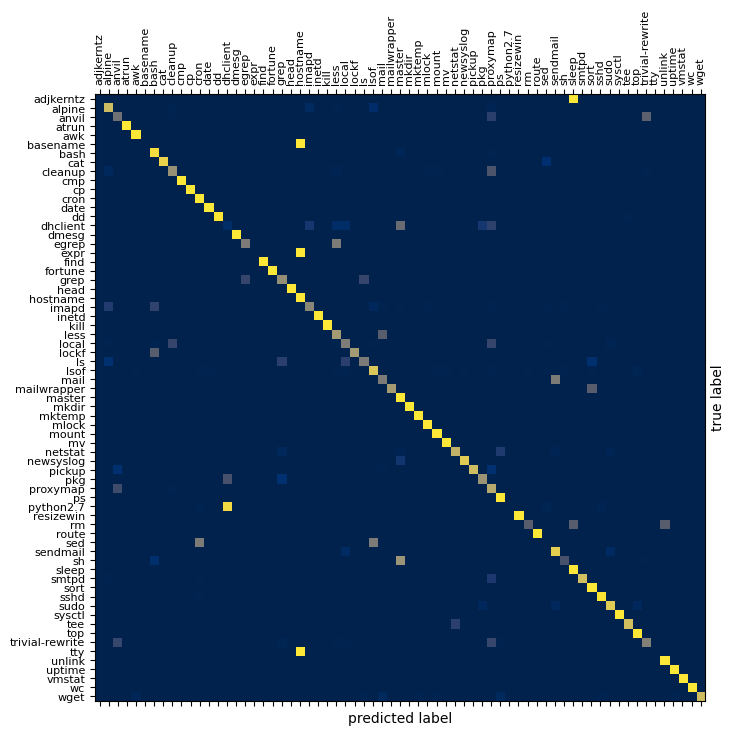

In [24]:
# print confusion matrix
# labels explicitly set, because current model may not predict all labels
conf_matrix = confusion_matrix(y_true, y_pred, labels=range(labels_cardinality), normalize='true')

# Replace all NaN values with 0
conf_matrix = np.nan_to_num(conf_matrix)

# Verify the distinct labels align correctly
distinct_labels = [labels_map[i] for i in range(labels_cardinality)]

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(20*cm, 20*cm))

ax.matshow(conf_matrix, cmap='cividis', aspect='auto')

# Set class names on axes
ax.set_xticks(range(len(distinct_labels)))
ax.set_yticks(range(len(distinct_labels)))
ax.set_xticklabels(distinct_labels, rotation=90, fontsize=8)
ax.set_yticklabels(distinct_labels, fontsize=8)

# Set axis labels "predicted" and "actual"
ax.set_xlabel('predicted label')
ax.set_ylabel('true label')
# y-axis label right side
ax.yaxis.set_label_position('right')

# set figsize
plt.savefig(f'{checkpoint_path}/confusion_matrix.svg')
plt.show()

In [25]:
unique_in_y_pred = [ labels_map[i] for i in np.unique(y_pred) ]
#print("Unique labels in y_pred:", unique_in_y_pred)

unique_not_in_y_pred = [ label for label in distinct_labels if label not in unique_in_y_pred ]
print("Unique labels not in y_pred:", unique_not_in_y_pred)

Unique labels not in y_pred: ['expr', 'python2.7']
